In [1]:
import sys, numpy, math, re
import scipy.stats as scipystats
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings

%matplotlib inline

sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/')
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/utilities')

import genomic_file_handlers as genome
from bedFileHandler import BedFile

# Deemed colorblind safe: http://colorbrewer2.org/#type=diverging&scheme=PiYG&n=4
highConfColor     ='#1b9e77'
medConfColor      ='#7570b3'
lowConfColor      ='#d95f02'
unclassifiedColor ='black'

In [2]:
warnings.filterwarnings("ignore")

In [3]:
reference_dir = '../../../../HCC1395/HighConfidenceCalls/truth_v1.1/'
armLoss = BedFile( os.path.join(reference_dir, 'BED/germline_chromosome_arm_loss.bed') )

In [4]:
goldset_snv   = os.path.join(reference_dir, 'sSNV.MSDUKT.superSet.v1.2.vcf.gz' )
goldset_indel = os.path.join(reference_dir, 'sINDEL.MDKT.superSet.v1.2.vcf.gz' )

In [5]:
ampliseq_snv_validation   = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/AmpliSeq.SNV.ValidationAnnotation.v1.2.tsv'
ampliseq_indel_validation = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/AmpliSeq.INDEL.ValidationAnnotation.v1.2.tsv'

In [6]:
goldTVAF        = []
nPASSES         = []
nREJECTS        = []
nNoCall         = []
NeuScall        = []
NeuEcall        = []
snvHighConf     = []
snvMedConf      = []
snvLowConf      = []
snvUnclassified = []
snvArmLoss      = []

with genome.open_textfile(goldset_snv) as vcfin:

    line_i = vcfin.readline().rstrip()

    while line_i.startswith('#'):
        line_i = vcfin.readline().rstrip()

    while line_i:

        vcf_i = genome.Vcf_line( line_i )
        if vcf_i.get_info_value('nREJECTS') != '.':
            goldTVAF.append( float(vcf_i.get_info_value('TVAF')) )
            nPASSES.append( int(vcf_i.get_info_value('nPASSES')) )
            nREJECTS.append( int(vcf_i.get_info_value('nREJECTS')) )
            nNoCall.append( int(vcf_i.get_info_value('nNoCall')) )
            NeuScall.append( int(vcf_i.get_info_value('NeuSomaticS')) )
            NeuEcall.append( int(vcf_i.get_info_value('NeuSomaticE')) )
        
            snvArmLoss.append( armLoss.inRegion( vcf_i.chromosome, vcf_i.position ) )

            if re.search(r'HighConf', vcf_i.filters):
                snvHighConf.append( True )
                snvMedConf.append( False )
                snvLowConf.append( False )
                snvUnclassified.append( False )

            elif re.search(r'MedConf', vcf_i.filters):
                snvHighConf.append( False )
                snvMedConf.append( True )
                snvLowConf.append( False )
                snvUnclassified.append( False )

            elif re.search(r'LowConf', vcf_i.filters):
                snvHighConf.append( False )
                snvMedConf.append( False )
                snvLowConf.append( True )
                snvUnclassified.append( False )

            elif re.search(r'Unclassified', vcf_i.filters):
                snvHighConf.append(  False )
                snvMedConf.append( False )
                snvLowConf.append( False )
                snvUnclassified.append( True )

        line_i = vcfin.readline().rstrip()

In [7]:
snvHighConf     = np.array(snvHighConf,     dtype=bool)
snvMedConf      = np.array(snvMedConf,      dtype=bool)
snvLowConf      = np.array(snvLowConf,      dtype=bool)
snvUnclassified = np.array(snvUnclassified, dtype=bool)
snvArmLoss      = np.array(snvArmLoss,      dtype=bool)
snvNotArmLoss   = np.invert(snvArmLoss)
goldTVAF        = np.array(goldTVAF)
nPASSES         = np.array(nPASSES)
nREJECTS        = np.array(nREJECTS)
nNoCall         = np.array(nNoCall)
NeuScall        = np.array(NeuScall)
NeuEcall        = np.array(NeuEcall)

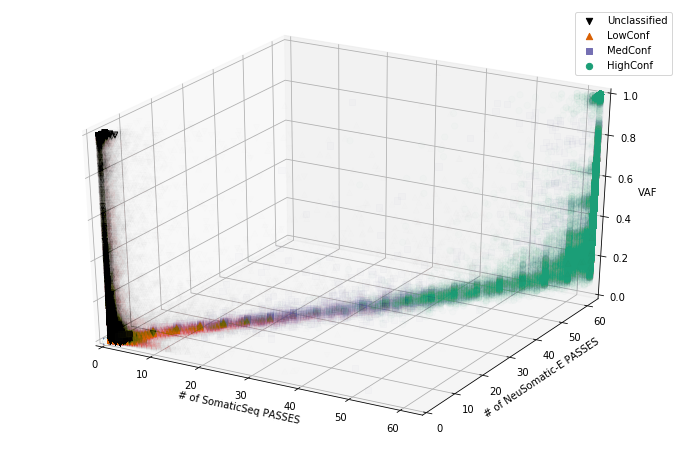

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

markersize = 40

ax.scatter(0,0,0, s=markersize, color=unclassifiedColor, marker='v' )
ax.scatter(0,0,0, s=markersize, color=lowConfColor, marker='^' )
ax.scatter(0,0,0, s=markersize, color=medConfColor, marker='s' )
ax.scatter(0,0,0, s=markersize, color=highConfColor, marker='o')
ax.scatter(0,0,0, s=markersize, color='white')

ax.scatter(nPASSES[  np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], \
           NeuEcall[ np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], \
           goldTVAF[ np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], \
           color=unclassifiedColor, s=markersize, marker='v', alpha=0.005 )

ax.scatter(nPASSES[  np.all( (snvLowConf, snvNotArmLoss), axis=0 ) ], \
           NeuEcall[ np.all( (snvLowConf, snvNotArmLoss), axis=0 ) ], \
           goldTVAF[ np.all( (snvLowConf, snvNotArmLoss), axis=0 ) ], \
           color=lowConfColor, s=markersize, marker='^', alpha=0.004 )

ax.scatter(nPASSES[  np.all( (snvMedConf, snvNotArmLoss), axis=0 ) ], \
           NeuEcall[ np.all( (snvMedConf, snvNotArmLoss), axis=0 ) ], \
           goldTVAF[ np.all( (snvMedConf, snvNotArmLoss), axis=0 ) ], \
           color=medConfColor, s=markersize, marker='s', alpha=0.02 )

ax.scatter(nPASSES[  np.all( (snvHighConf, snvNotArmLoss), axis=0 ) ], \
           NeuEcall[ np.all( (snvHighConf, snvNotArmLoss), axis=0 ) ], \
           goldTVAF[ np.all( (snvHighConf, snvNotArmLoss), axis=0 ) ], \
           color=highConfColor, s=markersize, marker='o', alpha=0.01 )


ax.legend(('Unclassified', 'LowConf', 'MedConf', 'HighConf'))

ax.set_xlim(0, 63)
ax.set_ylim(0, 63)
ax.set_zlim(0, 1)

ax.set_xlabel('# of SomaticSeq PASSES')
ax.set_ylabel('# of NeuSomatic-E PASSES')
ax.set_zlabel('VAF')

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_01a_somaticseq_vs_neusomatic_SNV.pdf', bbox_inches='tight' )

In [9]:
print('R(SomaticSeq & Neu-E): %.5g' % scipystats.pearsonr( nPASSES[ snvNotArmLoss],  NeuEcall[ snvNotArmLoss ])[0] )
print('R(SomaticSeq & Neu-S): %.5g' % scipystats.pearsonr( nPASSES[ snvNotArmLoss ], NeuScall[ snvNotArmLoss] )[0] )
print('R(  Neu-S    & Neu-E): %.5g' % scipystats.pearsonr( NeuScall[snvNotArmLoss ], NeuEcall[ snvNotArmLoss ])[0] )

R(SomaticSeq & Neu-E): 0.99662
R(SomaticSeq & Neu-S): 0.9859
R(  Neu-S    & Neu-E): 0.98703


In [10]:
NeuSNVCallHists   = [17919, 17923, 5920, 5823, 894, 778, 1187, 468, 492, 717, 391, 408, 584, 280, 309, 517, 213, 267, 379, 219, 199, 274, 154, 166, 212, 133, 157, 202, 146, 128, 167, 132, 147, 198, 153, 162, 241, 180, 195, 273, 196, 227, 339, 186, 245, 352, 202, 217, 351, 184, 242, 403, 192, 282, 541, 278, 340, 841, 405, 565, 2086, 872, 1721, 26446,]
NeuINDELCallHists = [ 9807,  4576, 1038,  545, 277, 193,  211, 139, 115, 115,  88, 110,  73,  85,  86,  86,  84,  51,  58,  72,  64,  66,  42,  41,  52,  55,  31,  54,  36,  52,  49,  54,  44,  56,  59,  45,  54,  65,  64,  66,  58,  51,  59,  41,  58,  51,  45,  61,  57,  62,  44,  51,  28,  54,  78,  61,  72,  88,  97,  87,  156, 169,  158,   372,]

neuCallHist = []
for n,i in enumerate(NeuSNVCallHists):
    for j in range(i):
        neuCallHist.append(n)
        
neuIndelCallHist = []
for n,i in enumerate(NeuINDELCallHists):
    for j in range(i):
        neuIndelCallHist.append(n)

In [11]:
print( sum(NeuSNVCallHists), sum(NeuSNVCallHists[0:9]), sum(NeuSNVCallHists[:-9:-1]) )
print( sum(NeuSNVCallHists[0:9])     / sum(NeuSNVCallHists) )
print( sum(NeuSNVCallHists[:-9:-1]) / sum(NeuSNVCallHists) )
print( (sum(NeuSNVCallHists[0:9]) + sum(NeuSNVCallHists[:-9:-1]) ) / sum(NeuSNVCallHists) )

print()
print( sum(NeuSNVCallHists), sum(NeuSNVCallHists[0:5]), sum(NeuSNVCallHists[:-5:-1]) )
print( (sum(NeuSNVCallHists[0:5]) + sum(NeuSNVCallHists[:-5:-1]) ) / sum(NeuSNVCallHists) )
print( (sum(NeuSNVCallHists[0:5]) ) / sum(NeuSNVCallHists) )
print( (sum(NeuSNVCallHists[:-5:-1]) ) / sum(NeuSNVCallHists) )

sum(NeuEcall[  np.all( (snvHighConf, snvNotArmLoss), axis=0 ) ] >= 40) / len(NeuEcall[  np.all( (snvHighConf, snvNotArmLoss), axis=0 ) ])

97020 51404 33276
0.5298289012574727
0.3429808286951144
0.8728097299525871

97020 48479 31125
0.8204906204906205
0.4996804782519068
0.3208101422387137


0.9775389058238408

In [12]:
NeuSNVCallHists[:5]

[17919, 17923, 5920, 5823, 894]

In [13]:
indelTVAF         = []
indel_size        = []
indelPASSES       = []
indelREJECTS      = []
indelNoCall       = []
indelNeuScall     = []
indelNeuEcall     = []
indelHighConf     = []
indelMedConf      = []
indelLowConf      = []
indelUnclassified = []
indelArmLoss      = []

with genome.open_textfile(goldset_indel) as vcfin:

    line_i = vcfin.readline().rstrip()

    while line_i.startswith('#'):
        line_i = vcfin.readline().rstrip()

    while line_i:

        vcf_i = genome.Vcf_line( line_i )
        if vcf_i.get_info_value('nREJECTS') != '.':
            indelTVAF.append( float(vcf_i.get_info_value('TVAF')) )
            indelPASSES.append( int(vcf_i.get_info_value('nPASSES')) )
            indelREJECTS.append( int(vcf_i.get_info_value('nREJECTS')) )
            indelNoCall.append( int(vcf_i.get_info_value('nNoCall')) )
            indelNeuScall.append( int(vcf_i.get_info_value('NeuSomaticS')) )
            indelNeuEcall.append( int(vcf_i.get_info_value('NeuSomaticE')) )
            indel_size.append( len(vcf_i.altbase) - len(vcf_i.refbase))
        
            indelArmLoss.append( armLoss.inRegion( vcf_i.chromosome, vcf_i.position ) )

            if re.search(r'HighConf', vcf_i.filters):
                indelHighConf.append( True )
                indelMedConf.append( False )
                indelLowConf.append( False )
                indelUnclassified.append( False )

            elif re.search(r'MedConf', vcf_i.filters):
                indelHighConf.append( False )
                indelMedConf.append( True )
                indelLowConf.append( False )
                indelUnclassified.append( False )

            elif re.search(r'LowConf', vcf_i.filters):
                indelHighConf.append( False )
                indelMedConf.append( False )
                indelLowConf.append( True )
                indelUnclassified.append( False )

            elif re.search(r'Unclassified', vcf_i.filters):
                indelHighConf.append(  False )
                indelMedConf.append( False )
                indelLowConf.append( False )
                indelUnclassified.append( True )

        line_i = vcfin.readline().rstrip()

In [14]:
indelHighConf     = np.array(indelHighConf, dtype=bool)
indelMedConf      = np.array(indelMedConf, dtype=bool)
indelLowConf      = np.array(indelLowConf, dtype=bool)
indelUnclassified = np.array(indelUnclassified, dtype=bool)
indelArmLoss      = np.array(indelArmLoss, dtype=bool)
indelNotArmLoss   = np.invert(indelArmLoss)
indelTVAF         = np.array(indelTVAF)
indelPASSES       = np.array(indelPASSES)
indelREJECTS      = np.array(indelREJECTS)
indelNoCall       = np.array(indelNoCall)
indelNeuScall     = np.array(indelNeuScall)
indelNeuEcall     = np.array(indelNeuEcall)
indel_size        = np.array(indel_size)

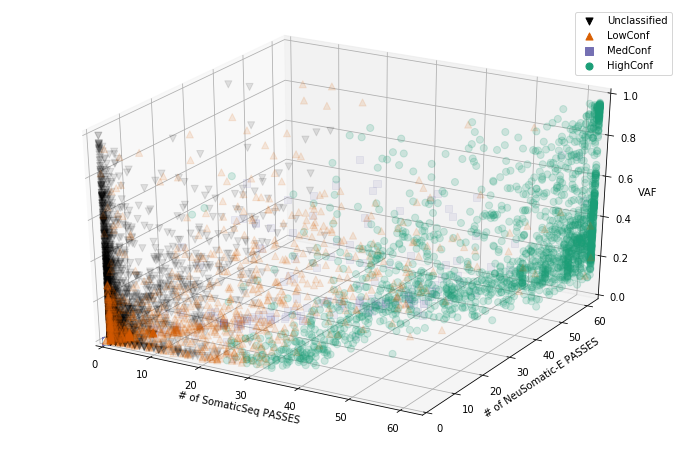

In [15]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

markersize = 50

ax.scatter(0,0,0, s=markersize, color=unclassifiedColor, marker='v' )
ax.scatter(0,0,0, s=markersize, color=lowConfColor, marker='^' )
ax.scatter(0,0,0, s=markersize, color=medConfColor, marker='s' )
ax.scatter(0,0,0, s=markersize, color=highConfColor, marker='o')
ax.scatter(0,0,0, s=markersize, color='white')

ax.scatter(indelPASSES[   np.all( (indelUnclassified, indelNotArmLoss), axis=0 ) ], \
           indelNeuEcall[ np.all( (indelUnclassified, indelNotArmLoss), axis=0 ) ], \
           indelTVAF[     np.all( (indelUnclassified, indelNotArmLoss), axis=0 ) ], \
           color=unclassifiedColor, s=markersize, marker='v', alpha=0.1 )

ax.scatter(indelPASSES[   np.all( (indelLowConf, indelNotArmLoss), axis=0 ) ], \
           indelNeuEcall[ np.all( (indelLowConf, indelNotArmLoss), axis=0 ) ], \
           indelTVAF[     np.all( (indelLowConf, indelNotArmLoss), axis=0 ) ], \
           color=lowConfColor, s=markersize, marker='^', alpha=0.12 )

ax.scatter(indelPASSES[   np.all( (indelMedConf, indelNotArmLoss), axis=0 ) ], \
           indelNeuEcall[ np.all( (indelMedConf, indelNotArmLoss), axis=0 ) ], \
           indelTVAF[     np.all( (indelMedConf, indelNotArmLoss), axis=0 ) ], \
           color=medConfColor, s=markersize, marker='s', alpha=0.1 )

ax.scatter(indelPASSES[   np.all( (indelHighConf, indelNotArmLoss), axis=0 ) ], \
           indelNeuEcall[ np.all( (indelHighConf, indelNotArmLoss), axis=0 ) ], \
           indelTVAF[     np.all( (indelHighConf, indelNotArmLoss), axis=0 ) ], \
           color=highConfColor, s=markersize, marker='o', alpha=0.18 )

ax.legend(('Unclassified', 'LowConf', 'MedConf', 'HighConf'))

ax.set_xlim(0, 63)
ax.set_ylim(0, 63)
ax.set_zlim(0, 1)

ax.set_xlabel('# of SomaticSeq PASSES')
ax.set_ylabel('# of NeuSomatic-E PASSES')
ax.set_zlabel('VAF')

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_01b_somaticseq_vs_neusomatic_indel.pdf', bbox_inches='tight' )

In [15]:
print('R(SomaticSeq & Neu-E): %.5g' % scipystats.pearsonr( indelPASSES[  indelNotArmLoss ], indelNeuEcall[ indelNotArmLoss ])[0] )
print('R(SomaticSeq & Neu-S): %.5g' % scipystats.pearsonr( indelPASSES[  indelNotArmLoss ], indelNeuScall[ indelNotArmLoss ])[0] )
print('R(  Neu-S    & Neu-E): %.5g' % scipystats.pearsonr( indelNeuScall[ indelNotArmLoss], indelNeuEcall[ indelNotArmLoss] )[0] )

R(SomaticSeq & Neu-E): 0.92452
R(SomaticSeq & Neu-S): 0.8622
R(  Neu-S    & Neu-E): 0.90561


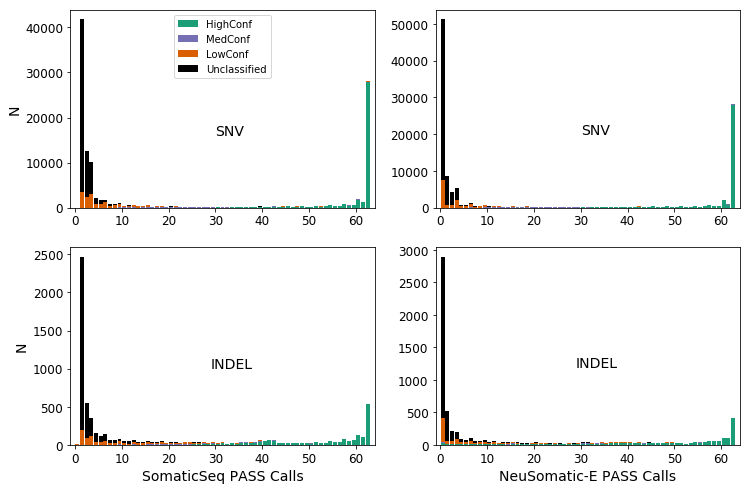

In [16]:
plt.figure(figsize=(12,8))

calledRange = np.linspace(0,63,64)

ax1 = plt.subplot(221)

t4 = plt.hist( nPASSES[  np.all( (snvHighConf,     snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( nPASSES[  np.all( (snvMedConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( nPASSES[  np.all( (snvLowConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( nPASSES[  np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((0,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf', 'Unclassified'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(30, 16000, 'SNV', size=14)

ax2 = plt.subplot(222, sharex=ax1)

t4 = plt.hist( NeuEcall[  np.all( (snvHighConf,     snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( NeuEcall[  np.all( (snvMedConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( NeuEcall[  np.all( (snvLowConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( NeuEcall[  np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((-1,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.text(30, 20000, 'SNV', size=14)


ax1 = plt.subplot(223)

t4 = plt.hist( indelPASSES[  np.all( (indelHighConf,     indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( indelPASSES[  np.all( (indelMedConf,      indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( indelPASSES[  np.all( (indelLowConf,      indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( indelPASSES[  np.all( (indelUnclassified, indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((0,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.ylabel('N', size=14)
_ = plt.xlabel('SomaticSeq PASS Calls', size=14)
_ = plt.text(29, 1000, 'INDEL', size=14)

ax2 = plt.subplot(224, sharex=ax1)

t4 = plt.hist( indelNeuEcall[  np.all( (indelHighConf,     indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( indelNeuEcall[  np.all( (indelMedConf,      indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( indelNeuEcall[  np.all( (indelLowConf,      indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( indelNeuEcall[  np.all( (indelUnclassified, indelNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((-1,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.xlabel('NeuSomatic-E PASS Calls', size=14)
_ = plt.text(29, 1200, 'INDEL', size=14)


#plt.savefig('Figures/pdf/PASS_Call_vs_ConfidenceLabel_Breakdown.pdf')
#plt.savefig('Figures/png/PASS_Call_vs_ConfidenceLabel_Breakdown.png')

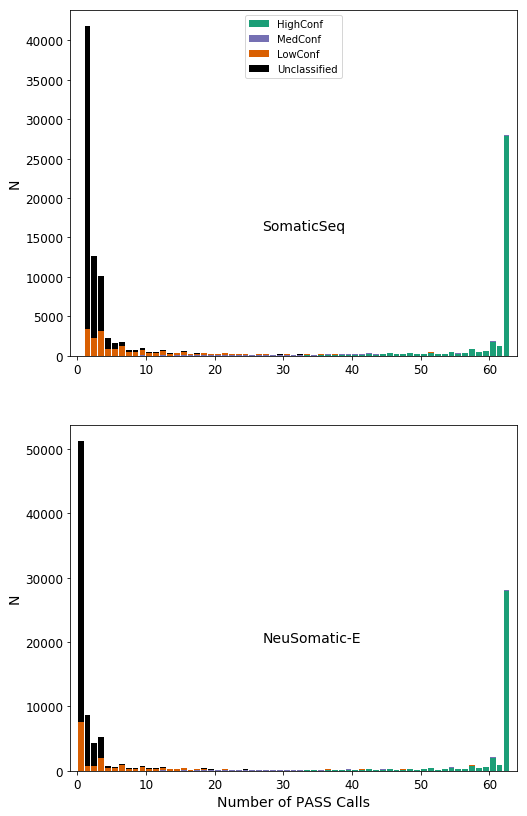

In [17]:
plt.figure(figsize=(8,14))

calledRange = np.linspace(0,63,64)

ax1 = plt.subplot(211)

t4 = plt.hist( nPASSES[  np.all( (snvHighConf,     snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( nPASSES[  np.all( (snvMedConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( nPASSES[  np.all( (snvLowConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( nPASSES[  np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((-1,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf', 'Unclassified'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(27, 16000, 'SomaticSeq', size=14)

ax2 = plt.subplot(212, sharex=ax1)

t4 = plt.hist( NeuEcall[  np.all( (snvHighConf,     snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=highConfColor)
t3 = plt.hist( NeuEcall[  np.all( (snvMedConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( NeuEcall[  np.all( (snvLowConf,      snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])
t1 = plt.hist( NeuEcall[  np.all( (snvUnclassified, snvNotArmLoss), axis=0 ) ], bins=calledRange, rwidth=0.85, color=unclassifiedColor, bottom=t4[0]+t3[0]+t2[0])

_ = plt.xlim((-1,64))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.text(27, 20000, 'NeuSomatic-E', size=14)
_ = plt.xlabel('Number of PASS Calls', size=14)
_ = plt.ylabel('N', size=14)


#plt.savefig('Figures/pdf/SomaticSeq_NeuSomatic_Sample_Count_Consistency.pdf')


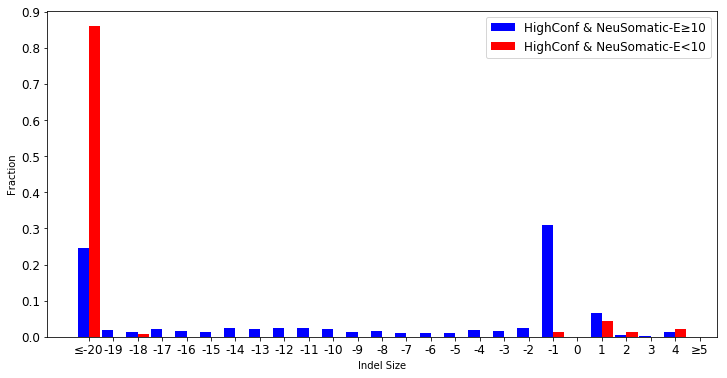

In [18]:
xbins = np.linspace(-20,5,26)

xbinlabels = np.linspace(-20,5,26)

xTicks     = [int(i) for i in xbinlabels]
xTicks[0]  = '≤' + str(xTicks[0])
xTicks[-1] = '≥' + str(xTicks[-1])


_ = plt.figure(figsize=(12,6))

_ = plt.hist(( np.clip(indel_size[np.all((indelHighConf,indelNotArmLoss,indelNeuEcall>=10), axis=0)], -20, 5), \
               np.clip(indel_size[np.all((indelHighConf,indelNotArmLoss,indelNeuEcall<10), axis=0)],  -20, 5)), \
             bins=xbins, rwidth=0.92, align='left', density=True, color=('blue', 'red'), )

_ = plt.legend( ('HighConf & NeuSomatic-E≥10', 'HighConf & NeuSomatic-E<10'), fontsize=12)

y_s = np.array((0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))
_   = plt.yticks(y_s/25*26, y_s, fontsize=12)
_   = plt.xticks(xbinlabels, xTicks, fontsize=12)

_ = plt.xlabel('Indel Size')
_ = plt.ylabel('Fraction')

#plt.savefig('Figures/pdf/indelSize_NeuSomatic_vs_NoNeuSomatic.pdf')

In [19]:
np.linspace(0,63,31)

array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ,
       23.1, 25.2, 27.3, 29.4, 31.5, 33.6, 35.7, 37.8, 39.9, 42. , 44.1,
       46.2, 48.3, 50.4, 52.5, 54.6, 56.7, 58.8, 60.9, 63. ])

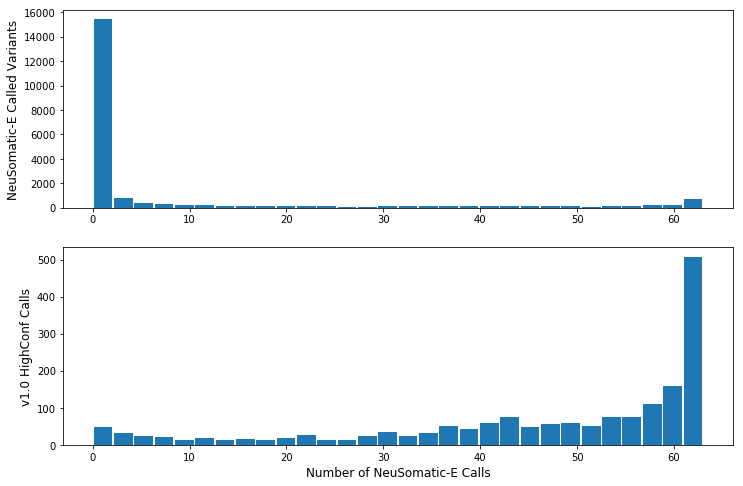

In [20]:
_ = plt.figure(figsize=(12,8))

_ = plt.subplot(211)
_ = plt.hist( neuIndelCallHist, bins=np.linspace(0,63,31), rwidth=0.92)
_ = plt.ylabel('NeuSomatic-E Called Variants', fontsize=12)

_ = plt.subplot(212)
_ = plt.hist( indelNeuEcall[  np.all( (indelHighConf, indelNotArmLoss), axis=0 ) ], bins=np.linspace(0,63,31), rwidth=0.92)
_ = plt.ylabel('v1.0 HighConf Calls', fontsize=12)
_ = plt.xlabel('Number of NeuSomatic-E Calls' , fontsize=12)
